In [1]:
import geopandas as gpd
import json
import ast

In [2]:
annotations = gpd.read_file("./data/slide-2024-04-03T07-52-35-R1-S2.geojson")

def polygon_to_yolo_bbox(geom, img_width, img_height, margin=20):
    minx, miny, maxx, maxy = geom.bounds

    minx -= margin
    miny -= margin
    maxx += margin
    maxy += margin
    
    # clip to image size (avoid negatives / overflow)
    minx = max(0, minx)
    miny = max(0, miny)
    maxx = min(img_width, maxx)
    maxy = min(img_height, maxy)

    # YOLO format: (x_center, y_center, w, h), normalized [0,1]
    x_center = (minx + maxx) / 2 / img_width
    y_center = (miny + maxy) / 2 / img_height
    w = (maxx - minx) / img_width
    h = (maxy - miny) / img_height
    
    return x_center, y_center, w, h



In [3]:
# extract unique class names
annotations["class_name"] = annotations["classification"].apply(lambda x: ast.literal_eval(x)["name"])
class_mapping = {name: i for i, name in enumerate(annotations["class_name"].unique())}
print(class_mapping)

{'veľké nepravidelné jadro': 0, 'veľké jadro': 1, 'nepravidelné jadro': 2, 'viacpočetné jadierka': 3, 'veľké jadierko': 4, 'mitóza': 5, 'hyperchrómne jadro': 6, 'referenčné bunky - erytrocyt': 7, 'referenčná bunky - lymfocyt': 8, 'viacjadrová bunka': 9}


In [8]:
W, H = 80000, 80000  # TODO: set your actual image size
MARGIN = 20

labels = []
for _, row in annotations.iterrows():
    cls = class_mapping[row["class_name"]]
    x, y, w, h = polygon_to_yolo_bbox(row["geometry"], W, H, margin=MARGIN)
    labels.append(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")


In [5]:
# save to .txt for YOLO
with open("slide-2024-04-03T07-52-35-R1-S2.txt", "w") as f:
    f.write("\n".join(labels))

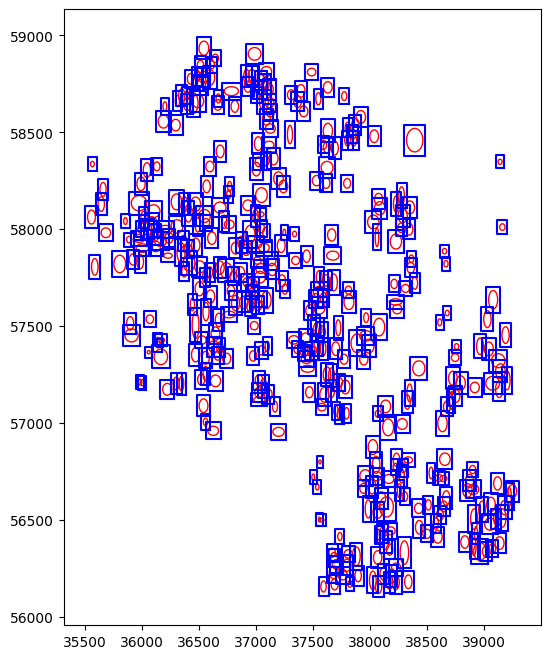

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import box

fig, ax = plt.subplots(figsize=(8,8))
annotations.plot(ax=ax, facecolor="none", edgecolor="red")

for _, row in annotations.iterrows():
    minx, miny, maxx, maxy = row["geometry"].bounds
    rect = box(minx-MARGIN, miny-MARGIN, maxx+MARGIN, maxy+MARGIN)  # with margin
    xs, ys = rect.exterior.xy
    ax.plot(xs, ys, color="blue")
plt.show()


# Remap to QuPath recognizable format

In [9]:
from shapely.geometry import mapping, box
import json

geojson_output = {"type": "FeatureCollection", "features": []}

for _, row in annotations.iterrows():
    minx, miny, maxx, maxy = row["geometry"].bounds
    rect = box(minx-MARGIN, miny-MARGIN, maxx+MARGIN, maxy+MARGIN)  # expanded bbox
    feature = {
        "type": "Feature",
        "geometry": mapping(rect),
        "properties": {
            "classification": row["classification"],  # keep original class info
        }
    }
    geojson_output["features"].append(feature)

with open("expanded_bboxes.geojson", "w") as f:
    json.dump(geojson_output, f)